<a href="https://colab.research.google.com/github/Thorwald89/HED-Pediatric-Malignancies-Analysis/blob/main/HED_Famiglie_NUOVO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# --- PASSO 1: Leggere i dati dal file Excel ---
file_name = "Analisi HED11.xlsx"

try:
    df = pd.read_excel(file_name, sheet_name="Analisi HED11")
    print(f"File '{file_name}' caricato con successo.")

    # # --- DEBUGGING: Stampare le colonne del DataFrame ---
    # print("\nDEBUG: Colonne presenti nel DataFrame dopo la lettura:")
    # print(df.columns.tolist())
    # print("\nDEBUG: Prime 5 righe del DataFrame:")
    # print(df.head())
    # print("\nDEBUG: Info sul DataFrame:")
    # df.info()
    # # --- FINE DEBUGGING ---

except FileNotFoundError:
    print(f"Errore: Il file '{file_name}' non è stato trovato. Assicurati che sia presente nell'ambiente di runtime di Colab o che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante la lettura del file Excel: {e}")
    exit()

# --- PASSO 2: Pulizia e preparazione dei dati ---

# Pulizia colonna 'età alla diagnosi'
if 'età alla diagnosi' in df.columns:
    df['età alla diagnosi'] = df['età alla diagnosi'].astype(str).str.replace(',', '.', regex=False)
    df['età alla diagnosi'] = pd.to_numeric(df['età alla diagnosi'], errors='coerce')
else:
    print("Errore: La colonna 'età alla diagnosi' non è presente nel file Excel.")
    exit()

# Pulizia e gestione NaN per la colonna 'DISEASE' (o 'Disease C' se è questa quella da usare per le categorizzazioni)
# Usiamo 'Disease C' per le categorizzazioni future, se confermato come la colonna target.
# Se 'Disease C' è già pulita e categorizzata, potremmo non aver bisogno di 'DISEASE' e delle sue elaborazioni.
# Per sicurezza, manteniamo l'elaborazione di 'DISEASE' ma useremo 'Disease C' per l'analisi specifica.

if 'DISEASE' in df.columns:
    df['DISEASE'] = df['DISEASE'].fillna('').astype(str).str.strip()
else:
    print("Avviso: La colonna 'DISEASE' non è presente. Le categorizzazioni basate su di essa potrebbero non essere accurate.")

# --- PASSO 3: Filtrare i pazienti per età ---
df_filtered = df[df['età alla diagnosi'] <= 20].copy()

if df_filtered.empty:
    print("Nessun paziente trovato con età alla diagnosi <= 20 anni.")
    exit()

# --- LOGICA DI CATEGORIZZAZIONE CENTRALIZZATA (per la tabella delle caratteristiche) ---
# Questa parte categorizza la colonna 'DISEASE' in 'DISEASE_CATEGORY_FINAL'
# che viene usata nella tabella delle caratteristiche.
# Per l'analisi HED vs Patologia, useremo 'Disease C' come richiesto.

# 1. Rinominazione preliminare delle categorie specifiche dalla colonna 'DISEASE'
rename_mapping = {
    'LLA': 'ALL',
    'LMA': 'AML',
    'Linfoma': 'Lymphoma',
    'LINFOMA H': 'Lymphoma H',
    'LINFOMA NH': 'Lymphoma NH',
    'BURKITT': 'Lymphoma NH',
    'LINFOMA REC': 'Lymphoma NH'
}

# Assicurati che 'DISEASE' esista per creare 'DISEASE_PROCESSED'
if 'DISEASE' in df_filtered.columns:
    df_filtered['DISEASE_PROCESSED'] = df_filtered['DISEASE'].replace(rename_mapping)
else:
    df_filtered['DISEASE_PROCESSED'] = '' # Placeholder se 'DISEASE' manca

# 2. Raggruppamento delle malattie con poche occorrenze in 'Other Hematological Diseases'
min_cases_for_separate_category = 5

disease_counts_for_grouping = df_filtered['DISEASE_PROCESSED'].value_counts()

diseases_to_group = disease_counts_for_grouping[disease_counts_for_grouping < min_cases_for_separate_category].index.tolist()

df_filtered['DISEASE_CATEGORY_FINAL'] = df_filtered['DISEASE_PROCESSED'].apply(
    lambda x: 'Other Hematological Diseases' if x in diseases_to_group else x
)


# --- PASSO 4: Calcolo delle statistiche sul DataFrame filtrato e categorizzato ---

total_patients_filtered = len(df_filtered)

# Statistiche sull'età alla diagnosi
if total_patients_filtered > 0:
    age_mean = df_filtered['età alla diagnosi'].mean()
    age_std = df_filtered['età alla diagnosi'].std()
    age_median = df_filtered['età alla diagnosi'].median()
    age_min = df_filtered['età alla diagnosi'].min()
    age_max = df_filtered['età alla diagnosi'].max()
else:
    age_mean, age_std, age_median, age_min, age_max = np.nan, np.nan, np.nan, np.nan, np.nan

# Distribuzione per sesso
if 'sex' in df_filtered.columns and total_patients_filtered > 0:
    df_filtered['sex_cleaned'] = df_filtered['sex'].fillna('').astype(str).str.strip()
    sex_counts = df_filtered['sex_cleaned'].value_counts(dropna=False)
    male_count = sex_counts.get('M', 0)
    female_count = sex_counts.get('F', 0)
    unknown_sex_count = total_patients_filtered - (male_count + female_count)
else:
    male_count, female_count, unknown_sex_count = 0, 0, 0
    if 'sex' not in df_filtered.columns and total_patients_filtered > 0 :
        print("Avviso: La colonna 'sex' non è presente. I conteggi per sesso saranno 0.")

# Distribuzione delle malattie categorizzate (usa 'DISEASE_CATEGORY_FINAL' per questa tabella)
if 'DISEASE_CATEGORY_FINAL' in df_filtered.columns and total_patients_filtered > 0:
    disease_category_counts = df_filtered['DISEASE_CATEGORY_FINAL'].value_counts()
else:
    disease_category_counts = pd.Series(dtype=int)

# --- PASSO 5: Preparazione e visualizzazione della tabella delle caratteristiche (STILE RICHIESTO) ---

# Inizializza la lista di righe per la tabella finale
final_table_rows = []

# --- Età alla Diagnosi ---
final_table_rows.append({"Characteristic": "Age at Diagnosis (years)", "Value": ""})
if total_patients_filtered > 0 and pd.notna(age_mean) and pd.notna(age_std):
    final_table_rows.append({"Characteristic": "Mean ± SD", "Value": f"{age_mean:.2f} ± {age_std:.2f}"})
else:
    final_table_rows.append({"Characteristic": "Mean ± SD", "Value": "N/A"})

if total_patients_filtered > 0 and pd.notna(age_median):
    final_table_rows.append({"Characteristic": "Median", "Value": f"{age_median:.2f}"})
else:
    final_table_rows.append({"Characteristic": "Median", "Value": "N/A"})

# --- Sesso ---
final_table_rows.append({"Characteristic": "Sex", "Value": ""})
if total_patients_filtered > 0:
    final_table_rows.append({
        "Characteristic": "Male (M)",
        "Value": f"{male_count} ({male_count/total_patients_filtered*100:.2f}%)"
    })
    final_table_rows.append({
        "Characteristic": "Female (F)",
        "Value": f"{female_count} ({female_count/total_patients_filtered*100:.2f}%)"
    })
else:
    final_table_rows.append({"Characteristic": "Male (M)", "Value": "0 (0.00%)"})
    final_table_rows.append({"Characteristic": "Female (F)", "Value": "0 (0.00%)"})

# --- Diagnosi Ematologica ---
final_table_rows.append({"Characteristic": "Hematological Diagnosis", "Value": ""})
desired_disease_categories_order = ["ALL", "AML", "Lymphoma H", "Lymphoma NH"]

if total_patients_filtered > 0:
    for category_name in desired_disease_categories_order:
        count = disease_category_counts.get(category_name, 0)
        final_table_rows.append({
            "Characteristic": f"   {category_name}",
            "Value": f"{count} ({count/total_patients_filtered*100:.2f}%)"
        })

    other_count = disease_category_counts.get("Other Hematological Diseases", 0)
    if other_count > 0:
        final_table_rows.append({
            "Characteristic": "   Other Hematological Diseases",
            "Value": f"{other_count} ({other_count/total_patients_filtered*100:.2f}%)"
        })

    for final_category in disease_category_counts.index:
        if final_category not in desired_disease_categories_order and final_category != "Other Hematological Diseases":
            count = disease_category_counts.get(final_category, 0)
            final_table_rows.append({
                "Characteristic": f"   {final_category}",
                "Value": f"{count} ({count/total_patients_filtered*100:.2f}%)"
            })
else:
    for category_name in desired_disease_categories_order:
        final_table_rows.append({
            "Characteristic": f"   {category_name}",
            "Value": "0 (0.00%)"
        })
    final_table_rows.append({
        "Characteristic": "   Other Hematological Diseases",
        "Value": "0 (0.00%)"
    })

# --- Totale Pazienti ---
final_table_rows.append({"Characteristic": "Total Patients", "Value": total_patients_filtered})

final_table_df = pd.DataFrame(final_table_rows)

print("\nTabella delle caratteristiche per pazienti con età alla diagnosi <= 20 anni (dati da Excel):")
print(final_table_df.to_markdown(index=False))

if 'HED_A' in df_filtered.columns and 'HED_B' in df_filtered.columns and 'HED_C' in df_filtered.columns:
    median_HED_A = df_filtered['HED_A'].median()
    median_HED_B = df_filtered['HED_B'].median()
    median_HED_C = df_filtered['HED_C'].median()

    print(f"\nMediana HED per HLA-A: {median_HED_A:.4f}")
    print(f"Mediana HED per HLA-B: {median_HED_B:.4f}")
    print(f"Mediana HED per HLA-C: {median_HED_C:.4f}")
else:
    print("\nAvviso: Colonne HED_A_Score, HED_B_Score o HED_C_Score non trovate per il calcolo delle mediane.")


# --- Funzione per formattare l'allele (già esistente) ---
def format_hla_allele(allele_str):
    if len(allele_str) < 3:
        return allele_str

    locus = allele_str[0]
    digits = allele_str[1:]

    if len(digits) >= 4:
        return f"{locus}*{digits[:2]}:{digits[2:4]}"
    elif len(digits) == 2:
        return f"{locus}*{digits}"
    else:
        return allele_str

# --- Sezione: Calcolo e Frequenza degli Alleli HLA ---
print("\n--- Frequenze degli Alleli HLA (dalla colonna 'Alleles') ---")

if 'Alleles' in df_filtered.columns:
    all_formatted_alleles = []
    for entry in df_filtered['Alleles'].dropna():
        individual_alleles = [a.strip() for a in str(entry).split(',') if a.strip()]
        for allele in individual_alleles:
            all_formatted_alleles.append(format_hla_allele(allele))

    if all_formatted_alleles:
        allele_counts = pd.Series(all_formatted_alleles).value_counts()
        total_alleles_counted = len(all_formatted_alleles)
        allele_frequencies = (allele_counts / total_alleles_counted) * 100

        allele_freq_df = pd.DataFrame({
            'Allele': allele_counts.index,
            'Count': allele_counts.values,
            'Frequency (%)': allele_frequencies.values
        })

        allele_freq_df = allele_freq_df.sort_values(by='Allele', ascending=True).reset_index(drop=True)

        print(f"Totale Alleli contati (dalla colonna 'Alleles', 6 per paziente): {total_alleles_counted}")

        output_excel_name_alleles = "HLA_Allele_Frequencies.xlsx"
        allele_freq_df.to_excel(output_excel_name_alleles, index=False)
        print(f"\nTabella delle frequenze alleliche esportata in '{output_excel_name_alleles}'")

        print("\n--- Tabella Frequenze Alleli HLA (formato TSV per Word) ---")
        print('\t'.join(allele_freq_df.columns))
        for index, row in allele_freq_df.iterrows():
            print('\t'.join(row.astype(str)))

    else:
        print("La colonna 'Alleles' è stata trovata, ma non contiene alleli validi dopo la pulizia e formattazione.")
else:
    print("Avviso: La colonna 'Alleles' NON è stata trovata nel dataset filtrato. Impossibile calcolare le frequenze degli alleli.")


# --- Sezione: Calcolo e Frequenza dei Genotipi HLA ---
print("\n--- Frequenze dei Genotipi HLA (dalla colonna 'Alleles') ---")

if 'Alleles' in df_filtered.columns:
    # Dizionari per tenere traccia dei genotipi per ciascun locus
    hla_a_genotypes = []
    hla_b_genotypes = []
    hla_c_genotypes = []

    # Processa ogni riga (paziente)
    for index, row in df_filtered.iterrows():
        alleles_string = str(row['Alleles'])

        individual_alleles_raw = [a.strip() for a in alleles_string.split(',') if a.strip()]

        locus_alleles_formatted = {'A': [], 'B': [], 'C': []}
        for allele_raw in individual_alleles_raw:
            if len(allele_raw) > 0:
                locus_char = allele_raw[0].upper()
                if locus_char in locus_alleles_formatted:
                    locus_alleles_formatted[locus_char].append(format_hla_allele(allele_raw))

        for locus, alleles_list in locus_alleles_formatted.items():
            if len(alleles_list) == 2:
                sorted_alleles_in_genotype = sorted(alleles_list)
                genotype_str = f"{sorted_alleles_in_genotype[0]}/{sorted_alleles_in_genotype[1]}"

                if locus == 'A':
                    hla_a_genotypes.append(genotype_str)
                elif locus == 'B':
                    hla_b_genotypes.append(genotype_str)
                elif locus == 'C':
                    hla_c_genotypes.append(genotype_str)
            elif len(alleles_list) == 1:
                genotype_str = f"{alleles_list[0]}/{alleles_list[0]}"
                if locus == 'A':
                    hla_a_genotypes.append(genotype_str)
                elif locus == 'B':
                    hla_b_genotypes.append(genotype_str)
                elif locus == 'C':
                    hla_c_genotypes.append(genotype_str)
            else:
                pass

    # Calcola e visualizza le frequenze per HLA-A
    if hla_a_genotypes:
        genotype_a_counts = pd.Series(hla_a_genotypes).value_counts()
        total_a_patients = len(hla_a_genotypes)
        genotype_a_frequencies = (genotype_a_counts / total_a_patients) * 100
        genotype_a_df = pd.DataFrame({
            'Genotype': genotype_a_counts.index,
            'Count': genotype_a_counts.values,
            'Frequency (%)': genotype_a_frequencies.values
        })
        genotype_a_df = genotype_a_df.sort_values(by='Genotype', ascending=True).reset_index(drop=True)
        print(f"\n--- HLA-A Genotype Frequencies (Total Patients with A-Genotype: {total_a_patients}) ---")
        output_excel_name_a = "HLA_A_Genotype_Frequencies.xlsx"
        genotype_a_df.to_excel(output_excel_name_a, index=False)
        print(f"Tabella esportata in '{output_excel_name_a}'")
        print(genotype_a_df.to_markdown(index=False))

    # Calcola e visualizza le frequenze per HLA-B
    if hla_b_genotypes:
        genotype_b_counts = pd.Series(hla_b_genotypes).value_counts()
        total_b_patients = len(hla_b_genotypes)
        genotype_b_frequencies = (genotype_b_counts / total_b_patients) * 100
        genotype_b_df = pd.DataFrame({
            'Genotype': genotype_b_counts.index,
            'Count': genotype_b_counts.values,
            'Frequency (%)': genotype_b_frequencies.values
        })
        genotype_b_df = genotype_b_df.sort_values(by='Genotype', ascending=True).reset_index(drop=True)
        print(f"\n--- HLA-B Genotype Frequencies (Total Patients with B-Genotype: {total_b_patients}) ---")
        output_excel_name_b = "HLA_B_Genotype_Frequencies.xlsx"
        genotype_b_df.to_excel(output_excel_name_b, index=False)
        print(f"Tabella esportata in '{output_excel_name_b}'")
        print(genotype_b_df.to_markdown(index=False))

    # Calcola e visualizza le frequenze per HLA-C
    if hla_c_genotypes:
        genotype_c_counts = pd.Series(hla_c_genotypes).value_counts()
        total_c_patients = len(hla_c_genotypes)
        genotype_c_frequencies = (genotype_c_counts / total_c_patients) * 100
        genotype_c_df = pd.DataFrame({
            'Genotype': genotype_c_counts.index,
            'Count': genotype_c_counts.values,
            'Frequency (%)': genotype_c_frequencies.values
        })
        genotype_c_df = genotype_c_df.sort_values(by='Genotype', ascending=True).reset_index(drop=True)
        print(f"\n--- HLA-C Genotype Frequencies (Total Patients with C-Genotype: {total_c_patients}) ---")
        output_excel_name_c = "HLA_C_Genotype_Frequencies.xlsx"
        genotype_c_df.to_excel(output_excel_name_c, index=False)
        print(f"Tabella esportata in '{output_excel_name_c}'")
        print(genotype_c_df.to_markdown(index=False))

    if not hla_a_genotypes and not hla_b_genotypes and not hla_c_genotypes:
        print("Nessun genotipo valido è stato estratto dalla colonna 'Alleles'.")
else:
    print("Avviso: La colonna 'Alleles' NON è stata trovata nel dataset filtrato. Impossibile calcolare le frequenze dei genotipi.")


# --- NUOVA SEZIONE: Associazione tra Profili HED e Patologie ---
print("\n--- Associazione tra Profili HED e Patologie ---")

# Colonne per l'analisi, usando i nomi confermati dall'utente
hed_profile_col = 'Allele' # Colonna che contiene i profili HED (es. HHH, LHH)
disease_target_col = 'Disease C' # Colonna che contiene le patologie da associare

# Verifica che le colonne esistano nel DataFrame filtrato
if hed_profile_col in df_filtered.columns and disease_target_col in df_filtered.columns:
    # Filtra il DataFrame per le colonne pertinenti per l'analisi di associazione
    # e rimuove eventuali NaN in queste colonne per la crosstab
    df_association = df_filtered.dropna(subset=[hed_profile_col, disease_target_col]).copy()

    if df_association.empty:
        print(f"Nessun dato valido trovato nelle colonne '{hed_profile_col}' e '{disease_target_col}' per l'analisi di associazione.")
    else:
        # Crea la tabella di contingenza
        contingency_table = pd.crosstab(df_association[hed_profile_col], df_association[disease_target_col])

        print("\nTabella di Contingenza (Profili HED vs. Patologie):")
        print(contingency_table.to_markdown())

        # Esegue il test Chi-quadro
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"\nRisultati del Test Chi-quadro:")
        print(f"Statistica Chi-quadro: {chi2:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Gradi di Libertà (dof): {dof}")

        # Interpretazione del p-value
        alpha = 0.05
        if p_value < alpha:
            print(f"Interpretazione: Il P-value ({p_value:.4f}) è inferiore al livello di significatività comune ({alpha}).")
            print("Questo suggerisce una associazione statisticamente significativa tra i profili HED e le categorie di patologie.")
        else:
            print(f"Interpretazione: Il P-value ({p_value:.4f}) è superiore al livello di significatività comune ({alpha}).")
            print("Non c'è evidenza sufficiente per suggerire una associazione statisticamente significativa tra i profili HED e le categorie di patologie sulla base di questo test.")

        # Avviso se ci sono celle con frequenze attese basse (per la validità del Chi-quadro)
        # Una buona regola empirica è che non più del 20% delle celle abbiano un valore atteso < 5
        # e che nessuna cella abbia un valore atteso < 1.
        low_expected_cells = (expected < 5).sum()
        total_cells = expected.size

        if (expected < 1).any():
            print("\nAvviso: Almeno una cella nella tabella delle frequenze attese ha un conteggio inferiore a 1.")
            print("Questo rende il test Chi-quadro inaffidabile. Considera di raggruppare categorie o usare un test esatto di Fisher.")
        elif low_expected_cells / total_cells > 0.2:
            print(f"\nAvviso: Il {low_expected_cells/total_cells*100:.2f}% delle celle ({low_expected_cells}/{total_cells}) nella tabella delle frequenze attese ha un conteggio inferiore a 5.")
            print("Questo potrebbe influire sull'affidabilità del test Chi-quadro. Potrebbe essere necessario un test esatto di Fisher se il numero di campioni è basso o raggruppare categorie.")

        # Puoi anche stampare la tabella delle frequenze attese per ispezione
        # print("\nFrequenze Attese:")
        # print(pd.DataFrame(expected, columns=contingency_table.columns, index=contingency_table.index).to_markdown())

else:
    print(f"Avviso: Una o entrambe le colonne '{hed_profile_col}' o '{disease_target_col}' non sono state trovate nel DataFrame filtrato.")
    print("Impossibile eseguire l'analisi di associazione tra profili HED e patologie.")

File 'Analisi HED11.xlsx' caricato con successo.

Tabella delle caratteristiche per pazienti con età alla diagnosi <= 20 anni (dati da Excel):
| Characteristic               | Value       |
|:-----------------------------|:------------|
| Age at Diagnosis (years)     |             |
| Mean ± SD                    | 9.56 ± 5.59 |
| Median                       | 9.53        |
| Sex                          |             |
| Male (M)                     | 72 (71.29%) |
| Female (F)                   | 28 (27.72%) |
| Hematological Diagnosis      |             |
| ALL                          | 38 (37.62%) |
| AML                          | 25 (24.75%) |
| Lymphoma H                   | 0 (0.00%)   |
| Lymphoma NH                  | 0 (0.00%)   |
| Other Hematological Diseases | 28 (27.72%) |
| Linfoma NH                   | 5 (4.95%)   |
| Linfoma H                    | 5 (4.95%)   |
| Total Patients               | 101         |

Mediana HED per HLA-A: 119364500000000.0000
Mediana HED p


--- Descriptive Statistics for HED Scores ---

HED_A:
  Mean: 3.37e+14
  Median: 1.21e+14
  Standard Deviation: 3.23e+14

HED_B:
  Mean: 5.16e+14
  Median: 6.44e+14
  Standard Deviation: 3.45e+14

HED_C:
  Mean: 3.19e+14
  Median: 3.39e+14
  Standard Deviation: 2.68e+14

--- Generating Violin Plots for HED Scores with individual points ---


<ipython-input-3-ca03aa89a7ff>:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='HED Locus', y='HED Score', data=df_hed_melted, inner='quartile', palette='viridis', alpha=0.7) # Aggiungi alpha per trasparenza del violino


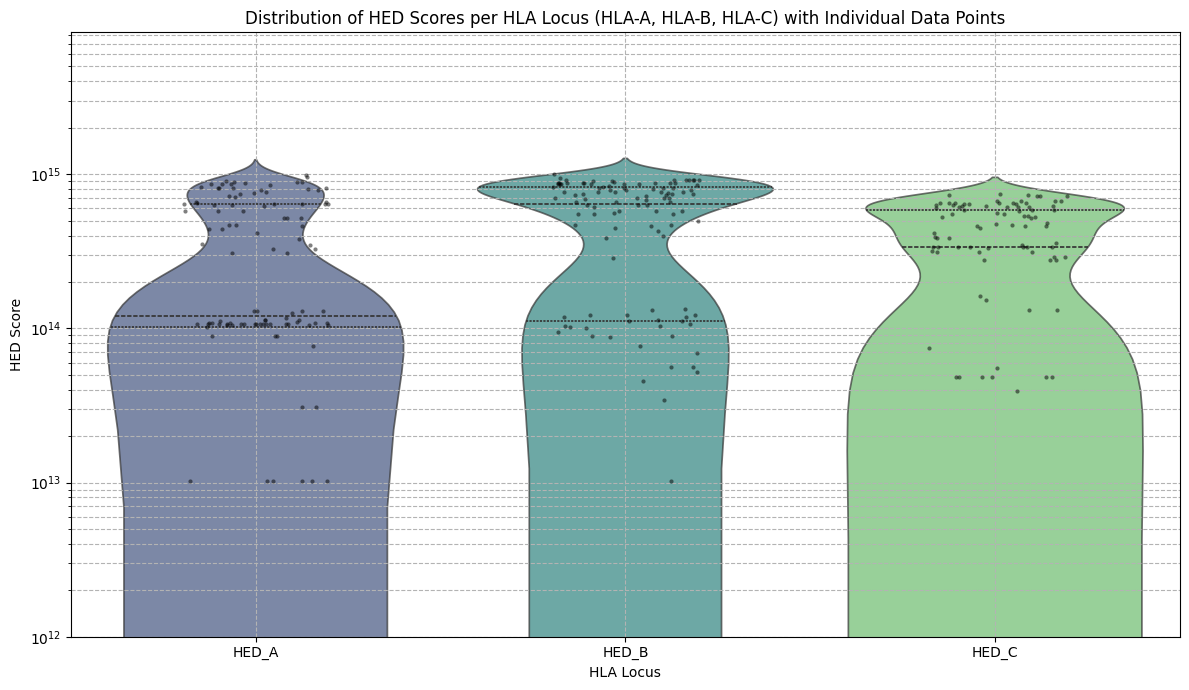


Violin plots with individual data points generated successfully.


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

# Dati HED forniti dall'utente (incollati qui come stringa multilinea)
hed_data_raw = """Alleles	HED_A	HED_B	HED_C
A0301,A2601,B3503,B3801,C0401,C1203	4,67E+14	7,22E+14	6,18E+14
A2402,A2601,B3502,B5501,C0401,C0102	1,30E+14	4,98E+14	6,43E+14
A0301,A2402,B3501,B3503,C0401,C0401	1,07E+14	0.856353591160221	0
A0301,A2402,B0702,B5105,C0401,C0702	1,07E+14	9,99E+14	6,71E+14
A0101,A3101,B0705,B3501,C0303,C1505	7,62E+14	9,14E+14	3,56E+14
A0101,A2301,B1801,B4901,C0701,C1203	1,14E+14	9,51E+14	4,47E+14
A0225,A24249,B1801,B1801,C07156,C07267	1,10E+14	0	1,52E+14
A0201,A6801,B3508,B4402,C0401,C0501	5,20E+14	7,69E+14	4,61E+14
A0101,A0301,B0801,B3502,C0401,C0701	5,75E+14	6,57E+14	6,49E+14
A0201,A0301,B3502,B3502,C0401,C0401	6,43E+14	0	0
A0301,A3201,B1801,B3503,C0401,C1203	6,32E+14	5,56E+14	6,18E+14
A2901,A6901,B0705,B0801,C0702,C1505	6,60E+14	4,55E+13	7,46E+13
A2402,A2601,B0801,B1302,C0602,C0702	1,30E+14	1,11E+14	3,39E+14
A2402,A3001,B3501,B4402,C0401,C0501	1,08E+14	8,10E+14	4,61E+14
A0101,A0201,B3502,B4403	1,05E+14	7,93E+14	0
A0201,A3201,B3501,B3502,C0401,C0401	1,03E+13	1,04E+14	0
A0201,A2402,B1518,B1801,C0701,C0704	1,07E+14	4,25E+14	2,76E+14
A0301,A2402,B3501,B3502,C0401,C04105N	1,07E+14	1,04E+14	NA
A0207,A2402,B3511,B4601,C0151,C0373	1,17E+14	5,51E+14	6,04E+14
A0205,A2402,B3502,B3502,C0401,C0401	1,08E+14	0	0
A1101,A2901,B0705,B3501	5,20E+14	9,14E+14	0
A0201,A2501,B1801,B3901,C1203,C1203	1,25E+14	4,60E+14	0
A0201,A1101,B5101,B5301,C0401,C1602	8,10E+14	3,45E+13	6
A0201,A6802,B3501,B5301,C0401,C0401	4,18E+14	2,86E+14	0
A0101,A0101,B0801,B3701,C0602,C0701	0	8,44E+14	3,12E+14
A0301,A2402,B5101,B5101,C0102,C1402	1,07E+14	0	3,48E+14
A0101,A0201,B1517,B1801,C0701,C0701	1,05E+14	1,19E+14	0
A6801,A6801,B5101,B5101,C0202,C1502	0	0	3,30E+14
A0201,A2402,B1509,B1801,C0701,C0704	1,07E+14	5,18E+13	2,76E+14
A0201,A0201,B1501,B3701,C0303,C0602	0	9,12E+14	7,28E+14
A0201,A0201,B1801,B5101,C0701,C1402	0	8,73E+14	5,16E+14
A0301,A1101,B1801,B5101,C0701,C1502	3,08E+13	8,73E+14	6,09E+14
A0201,A0301,B1801,B5101,C0701,C1504	6,43E+14	8,73E+14	4,83E+14
A0301,A3101,B3503,B4701,C0401,C0602	3,55E+14	8,22E+14	4,82E+13
A1101,A3001,B1302,B3501,C0401,C0602	6,23E+14	8,64E+14	4,82E+13
A0201,A3101,B3503,B4002,C0202,C0401	7,52E+14	6,83E+14	6
A1101,A3201,B4002,B5501,C0202,C0303	7,18E+14	8,17E+14	4,67E+14
A0201,A1101,B1302,B5501,C0303,C0602	8,10E+14	8,72E+14	7,28E+14
A0201,A0301,B3502,B4402,C0401,C0501	6,43E+14	8,88E+14	4,61E+14
A1101,A2601,B0702,B3501,C0401,C0702	3,78E+14	9,01E+14	6,71E+14
A0101,A3001,B1302,B3503,C0401,C0602	9,08E+14	7,96E+14	4,82E+13
A0201,A3002,B1302,B1801	8,94E+14	9,17E+14	0
A3004,A6801,B4402,B5001	5,76E+14	7,54E+14	0
A3002,A3201,B1302,B1801,C0501,C0602	7,10E+14	9,17E+14	5,52E+14
A2501,A3303,B2705,B5801,C0202,C0302	8,48E+14	1,12E+14	3,16E+14
A0301,A3001,B0702,B1302,C0602,C0702	4,44E+14	1,22E+14	3,39E+14
A0101,A0101,B3701,B5101,C0602,C1402	0	8,60E+14	3,92E+14
A0201,A6601,B4102,B5101,C1513,C1703	8,62E+14	1,04E+14	3,91E+13
A0301,A3201,B1402,B1517,C0701,C0802	6,32E+14	1,18E+14	6,42E+14
A0101,A2301,B1517,B4901,C0701,C0701	1,14E+14	7,38E+14	0
A0101,A0205,B0801,B1801,C0701,C0701	1,07E+14	7,69E+14	0
A0201,A0201,B1801,B5101,C0701,C1602	0	8,73E+14	5,26E+14
A0201,A3201,B3801,B5001,C0602,C1203	1,03E+13	9	2,90E+14
A0201,A0206,B1801,B5101,C0701,C1502	0.121546961325967	8,73E+14	6,09E+14
A2402,A2402,B3501,B5201,C0401,C0202	0	7,40E+14	6
A0101,A0103,B3508,B3924,C0401,C0701	0.0552486187845304	7,71E+14	6,49E+14
A2402,A2402,B1402,B3508,C0401,C0802	0	7,93E+14	5,38E+14
A0301,A1101,B1801,B5101,C0701,C1502	3,08E+13	8,73E+14	6,09E+14
A0301,A0301,B0801,B3501,C0401,C0701	0	7,38E+14	6,49E+14
A0101,A0201,B3501,B5101,C0202,C0401	1,05E+14	6,31E+14	6
A0101,A3201,B1302,B3501,C0401,C0602	8,92E+13	8,64E+14	4,82E+13
A0201,A3201,B1501,B5101	1,03E+13	7,44E+14	0
A0201,A0201,B4405,B5101,C0202,C0202	0	8,14E+14	0
A0201,A3201,B1801,B4001,C0401,C0701	1,03E+13	6,96E+14	6,49E+14
A0201,A2402,B3901,B3901,C0702,C1203	1,07E+14	0	4,75E+14
A0101,A0201,B4402,B5701,C0501,C0602	1,05E+14	9,54E+13	5,52E+14
A1101,A2402,B3501,B3508,C0401,C0401	1,09E+14	0.56353591160221	0
A0201,A2902,B1402,B4501,C0202,C0602	7,42E+14	8,64E+14	3,83E+14
A2402,A6802,B1402,B1501,C0303,C0802	1,02E+14	6,99E+14	4,15E+14
A0101,A6802,B0702,B0801,C0701,C0702	8,30E+14	4,68E+14	1,31E+14
A0301,A2902,B0801,B5001,C0602,C0702	3,26E+14	8,92E+13	3,39E+14
A0301,A6801,B1807,B5101,C1203,C1203	3,07E+14	7,88E+14	0
A0201,A2402,B4101,B4403,C0401,C1602	1,07E+14	8,61E+14	6
A0201,A3201,B3503,B4901,C0401,C0602	1,03E+13	8,31E+14	4,82E+13
A1101,A2426,B3501,B4001,C0401,C0401	1,11E+14	7,73E+13	0
A0205,A3101,B4427,B5108,C0704,C1602	7,90E+14	7,40E+14	5,74E+14
A2402,A2601,B1801,B5108,C0701,C1602	1,30E+14	9,02E+14	5,26E+14
A0301,A0302,B3501,B3501,C0401,C0401	1,29E+14	0	0
A0101,A2402,B0801,B3502,C0401,C0701	1,06E+14	6,57E+14	6,49E+14
A0301,A6801,B3503,B5101,C0401,C1513	3,07E+14	5,64E+13	6,10E+14
A2402,A3002,B1509,B4901,C0701,C0704	9,91E+14	6,92E+13	2,76E+14
A2318,A3002,B1402,B4901,C0701,C0802	8,83E+14	8,91E+13	6,42E+14
A0301,A2902,B0702,B1402,C0702,C0802	3,26E+14	7,03E+14	6,70E+14
A0201,A1101,B1503,B3801	8,10E+14	6,86E+14	0
A0301,A2601,B0702,B1302,C0602,C0702	4,67E+14	1,22E+14	3,39E+14
A0302,A2485,B3502,B5101,C04264,C1502	9,54E+14	5,51E+14	6,31E+14
A0201,A7403,B3503,B5101,C0401,C1602	6,63E+14	5,64E+13	6
A0101,A3301,B0702,B0801,C0701,C0702	7,86E+14	4,68E+14	1,31E+14
A2901,A3201,B0705,B5001,C0602,C1505	6,51E+14	1,01E+14	5,86E+14
A0205,A3001,B1302,B1401,C0602,C0802	8,62E+14	1,06E+14	6,30E+14
A0201,A3601,B1518,B5301	8,85E+14	6,27E+14	0
A0101,A0301,B0702,B5201	5,75E+14	1,13E+14	0
A2901,A3001,B0705,B5101	4,62E+14	1,02E+14	0
A3002,A6901,B0702,B1801,C0501,C0702	8,04E+14	8,81E+13	7,47E+14
A0201,A3301,B1402,B1501,C0401,C0802	7,73E+13	6,99E+14	5,38E+14
A2402,A3101,B3901,B5002,C0602,C1203	1,07E+14	8	2,90E+14
A0101,A3201,B0801,B1801,C0501,C0701	8,92E+13	7,69E+14	7,19E+14
A0301,A2402,B1801,B5101,C0102,C0102	1,07E+14	8,73E+14	0
A0301,A2402,B0702,B3502,C0401,C0702	1,07E+14	8,46E+14	6,71E+14
A0201,A2402,B2705,B4402,C0202,C0501	1,07E+14	9,20E+14	3,35E+14
A2301,A2402,B3508,B4403,C0401,C0401	1,08E+14	7,72E+14	0
A0101,A2301,B1302,B4901,C0602,C0701	1,14E+14	5,54E+14	3,12E+14
A0101,A3201,B1801,B3502,C0401,C1203	8,92E+13	5,75E+14	6,18E+14
A0201,A3201,B3501,B5101	1,03E+13	6,31E+14	0
A0101,A0101,B3502,B3502	0	0	0
A0101,A0101,B4901,B5201,C0701,C0202	0	3,84E+14	5,83E+14
A0201,A1101,B1518,B5501,C0303,C0704	8,10E+14	5,74E+14	7,21E+14
A0301,A0301,B4002,B5001,C0202,C0602	0	4,48E+14	3,83E+14
A3001,A3001,B3501,B4201,C0401,C1701	0	8,17E+14	5,61E+14
A0301,A0201,B3801,B4901,C0308,C0701	6,43E+14	6,14E+14	5,85E+14
A2402,A3001,B1302,B1801,C0602,C0701	1,08E+14	9,17E+14	3,12E+14
A0101,A0205,B0801,B5801,C0302,C0701	1,07E+14	1,33E+14	5,54E+13
A0201,A3002,B1801,B5001,C0401,C0701	8,94E+14	6,65E+14	6,49E+14
A0201,A6601,B1801,B5702,C0701,C0701	8,62E+14	1,32E+14	0
A6801,A7401,B4403,B5802,C0401,C0602	3,45E+14	8,63E+14	4,82E+13
A0301,A3001,B1302,B0702,C0702,C0602	4,44E+14	1,22E+14	3,39E+14
A2601,A2902,B1801,B3502,C1203,C1601	5,18E+14	5,75E+14	1,63E+14
A0201,A0201,B0702,B5001,C0702,C0602	0	1,02E+13	3,39E+14
A0201,A0301,B1518,B1573,C0303,C0704	6,43E+14	3,95E+14	7,21E+14
"""

# Crea un DataFrame dai dati HED grezzi
df_hed = pd.read_csv(StringIO(hed_data_raw), sep='\t')

# --- Pulizia e conversione degli score HED ---
def clean_hed_value(value):
    if pd.isna(value):
        return np.nan
    s_value = str(value).strip().replace(',', '.')
    try:
        return float(s_value)
    except ValueError:
        return np.nan

for col in ['HED_A', 'HED_B', 'HED_C']:
    df_hed[col] = df_hed[col].apply(clean_hed_value)

df_hed_cleaned = df_hed.dropna(subset=['HED_A', 'HED_B', 'HED_C']).copy()

# --- Analisi Statistiche Descrittive degli Score HED ---
print("\n--- Descriptive Statistics for HED Scores ---")
for col in ['HED_A', 'HED_B', 'HED_C']:
    mean_val = df_hed_cleaned[col].mean()
    median_val = df_hed_cleaned[col].median()
    std_val = df_hed_cleaned[col].std()
    print(f"\n{col}:")
    print(f"  Mean: {mean_val:.2e}")
    print(f"  Median: {median_val:.2e}")
    print(f"  Standard Deviation: {std_val:.2e}")


# --- Generazione dei Violin Plots con punti individuali e scala y personalizzata ---
print("\n--- Generating Violin Plots for HED Scores with individual points ---")

df_hed_melted = df_hed_cleaned.melt(value_vars=['HED_A', 'HED_B', 'HED_C'],
                                     var_name='HED Locus',
                                     value_name='HED Score')

plt.figure(figsize=(12, 7))
sns.violinplot(x='HED Locus', y='HED Score', data=df_hed_melted, inner='quartile', palette='viridis', alpha=0.7) # Aggiungi alpha per trasparenza del violino
sns.stripplot(x='HED Locus', y='HED Score', data=df_hed_melted, jitter=0.2, color='black', size=3, alpha=0.5) # Aggiungi i punti individuali
plt.title('Distribution of HED Scores per HLA Locus (HLA-A, HLA-B, HLA-C) with Individual Data Points')
plt.xlabel('HLA Locus')
plt.ylabel('HED Score')
plt.yscale('log')
plt.ylim(1e12, None) # Imposta il limite inferiore a 10^12
plt.grid(True, which="both", ls="--", c=".7")
plt.tight_layout()
plt.show()

print("\nViolin plots with individual data points generated successfully.")

Valori mancanti prima della pulizia:
 Sample               3
Alleles              3
HED_A                3
HED_B                3
HED_C                4
HED_A_M              3
HED_B_M              4
HED_C_M              6
Allele               3
DISEASE              3
Disease C            3
birthdate            3
sex                  3
datediagnosi         3
età alla diagnosi    3
dtype: int64
Colonna 'età alla di' non trovata. Calcolo l'età da 'birthdate' e 'datediagnosi'.

Esclusi 21 soggetti con età alla diagnosi maggiore di 20 anni.
Numero di soggetti rimanenti: 101
Soggetti dopo rimozione righe con Allele o DISEASE vuoti: 101

--- Tabella delle Caratteristiche dei Pazienti (dopo filtro età e pulizia) ---
Età alla diagnosi (anni):
  Media ± DS: 9.56 ± 5.59
  Mediana: 9.52

Sesso:
  M: 73 (72.28%)
  F: 28 (27.72%)

Diagnosi Ematologica:
  LLA: 38 (37.62%)
  LMA: 25 (24.75%)
  Linfoma NH: 5 (4.95%)
  Linfoma H: 5 (4.95%)
  LLA REC: 4 (3.96%)
  SAA: 4 (3.96%)
  LLA B: 3 (2.97%)
  MDS: 

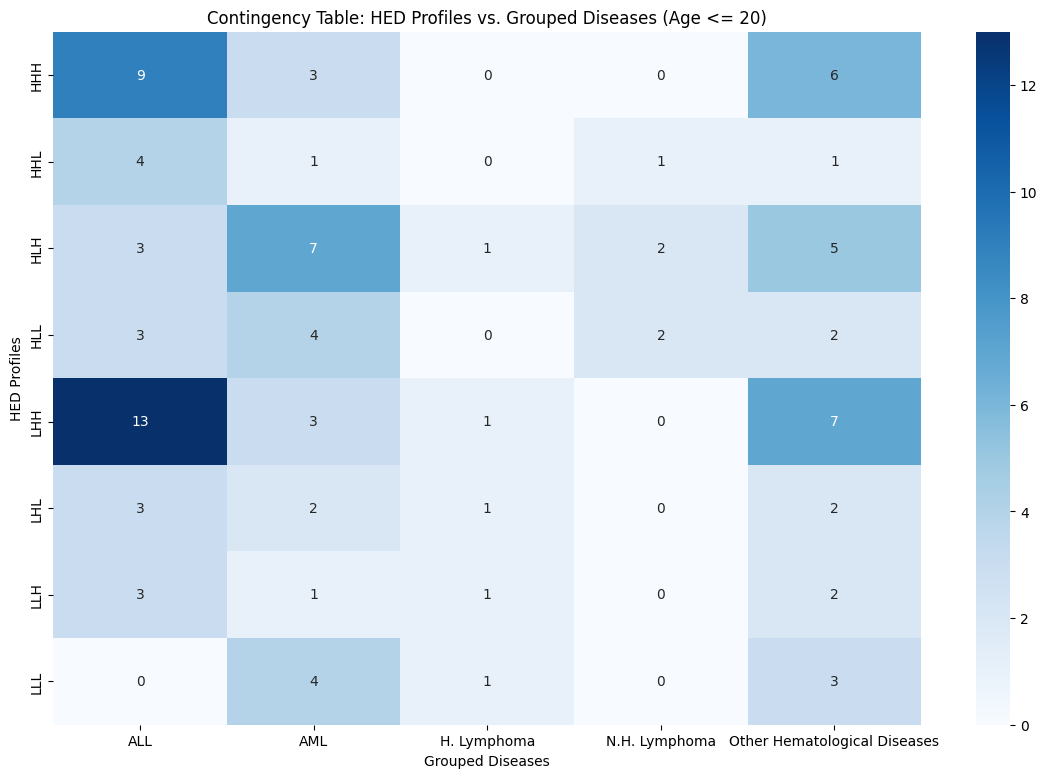


--- Analisi HHH/LLL vs LLA/LMA (dati filtrati - USO TEST ESATTO DI FISHER) ---
Tabella di contingenza (HHH/LLL vs LLA/LMA):
DISEASE_RENAMED  ALL  AML
Allele                   
HHH                9    3
LLL                0    4


Test Esatto di Fisher (HHH/LLL vs LLA/LMA):
Odds Ratio: inf
p-value: 0.0192
Esiste una relazione significativa tra l'allele (HHH/LLL) e la malattia (LLA/LMA) (Test Esatto di Fisher).


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Leggi il file Excel e il foglio specifico
df = pd.read_excel("Analisi HED11.xlsx", sheet_name="Analisi HED11")

# --- 1. Pulizia e Preparazione Dati ---
print("Valori mancanti prima della pulizia:\n", df.isnull().sum())

# Assicurati che le colonne 'Allele' e 'DISEASE' siano stringhe e gestisci i NaN
df['Allele'] = df['Allele'].fillna('').astype(str)
df['DISEASE'] = df['DISEASE'].fillna('').astype(str)

# Rimuovi spazi vuoti e caratteri speciali in eccesso da ogni elemento
df['Allele'] = df['Allele'].apply(lambda x: x.strip())
df['DISEASE'] = df['DISEASE'].apply(lambda x: x.strip())

# Calcolo dell'età alla diagnosi e applicazione del filtro
# Assumo che 'età alla di' sia già l'età numerica, altrimenti la calcolo
if 'età alla di' in df.columns:
    df['AgeAtDiagnosis'] = df['età alla di'] # Crea una colonna standardizzata per l'età
else:
    print("Colonna 'età alla di' non trovata. Calcolo l'età da 'birthdate' e 'datediagnosi'.")
    if 'birthdate' in df.columns and 'datediagnosi' in df.columns:
        df['birthdate'] = pd.to_datetime(df['birthdate'])
        df['datediagnosi'] = pd.to_datetime(df['datediagnosi'])
        df['AgeAtDiagnosis'] = (df['datediagnosi'] - df['birthdate']).dt.days / 365.25
    else:
        print("Errore: Impossibile calcolare l'età. Colonne 'birthdate' o 'datediagnosi' non trovate.")
        # Potresti voler uscire dallo script qui o gestire l'errore in altro modo
        exit()

# --- FILTRO SOGGETTI CON ETÀ > 20 ---
initial_patient_count = len(df)
df_cleaned = df[df['AgeAtDiagnosis'] <= 20].copy()
patients_excluded = initial_patient_count - len(df_cleaned)
print(f"\nEsclusi {patients_excluded} soggetti con età alla diagnosi maggiore di 20 anni.")
print(f"Numero di soggetti rimanenti: {len(df_cleaned)}")


# --- Gestione dei casi con Allegato vuoto o Diagnosi vuota dopo il filtro ---
# Questi possono derivare da righe che avevano problemi o erano NaN prima della pulizia
# e che non sono state rimosse da fillna('') e strip() perché i dati c'erano ma vuoti
# Assicurati che le colonne chiave non abbiano stringhe vuote residue che possano creare problemi
df_cleaned = df_cleaned[df_cleaned['Allele'] != ''].copy()
df_cleaned = df_cleaned[df_cleaned['DISEASE'] != ''].copy()
print(f"Soggetti dopo rimozione righe con Allele o DISEASE vuoti: {len(df_cleaned)}")


# --- 2. Generazione della Tabella delle Caratteristiche dei Pazienti (con i dati filtrati) ---
print("\n--- Tabella delle Caratteristiche dei Pazienti (dopo filtro età e pulizia) ---")

# Età alla diagnosi (ora usa la colonna 'AgeAtDiagnosis' che è stata creata/normalizzata)
eta_media = df_cleaned['AgeAtDiagnosis'].mean()
eta_mediana = df_cleaned['AgeAtDiagnosis'].median()
eta_std = df_cleaned['AgeAtDiagnosis'].std()
print(f"Età alla diagnosi (anni):")
print(f"  Media ± DS: {eta_media:.2f} ± {eta_std:.2f}")
print(f"  Mediana: {eta_mediana:.2f}")

# Sesso
if 'sex' in df_cleaned.columns:
    # Riempi eventuali NaN o stringhe vuote nella colonna 'sex' prima di contare
    df_cleaned['sex_cleaned'] = df_cleaned['sex'].fillna('').astype(str).apply(lambda x: x.strip())
    sesso_counts = df_cleaned['sex_cleaned'].value_counts(normalize=True) * 100
    print("\nSesso:")
    for sex_val, percent in sesso_counts.items():
        if sex_val == '': # Gestisci la categoria vuota se presente
            sex_label = "Sconosciuto/Mancante"
        else:
            sex_label = sex_val
        count = df_cleaned['sex_cleaned'].value_counts()[sex_val]
        print(f"  {sex_label}: {count} ({percent:.2f}%)")
else:
    print("Colonna 'sex' non trovata.")


# Diagnosi Ematologica (usa la colonna 'DISEASE' già pulita e filtrata)
print("\nDiagnosi Ematologica:")
disease_counts = df_cleaned['DISEASE'].value_counts(normalize=True) * 100
for disease, percent in disease_counts.items():
    count = df_cleaned['DISEASE'].value_counts()[disease]
    print(f"  {disease}: {count} ({percent:.2f}%)")


# --- 3. Analisi di Contingenza Generale (profili HED vs tutte le malattie raggruppate) ---
print("\n--- Analisi di Contingenza Generale (profili HED vs tutte le malattie raggruppate) ---")

# Raggruppamento delle malattie per affrontare il problema delle celle sparse (come discusso)
min_cases_for_separate_category = 5 # Puoi modificare questa soglia
disease_counts_for_grouping = df_cleaned['DISEASE'].value_counts()
diseases_to_group = disease_counts_for_grouping[disease_counts_for_grouping < min_cases_for_separate_category].index.tolist()

df_grouped = df_cleaned.copy()
df_grouped['DISEASE_GROUPED'] = df_grouped['DISEASE'].apply(
    lambda x: 'Other Hematological Diseases' if x in diseases_to_group else x
)

# --- Rinominazione delle etichette per il grafico ---
rename_mapping = {
    'LLA': 'ALL',
    'LMA': 'AML',
    'Linfoma H': 'H. Lymphoma',
    'Linfoma NH': 'N.H. Lymphoma'
}
df_grouped['DISEASE_GROUPED_RENAMED'] = df_grouped['DISEASE_GROUPED'].replace(rename_mapping)


contingency_table_grouped = pd.crosstab(df_grouped['Allele'], df_grouped['DISEASE_GROUPED_RENAMED']) # Usa la nuova colonna rinominata

print("\nTabella di contingenza raggruppata:")
print(contingency_table_grouped)

# Chi-squared test of independence sul dataframe raggruppato
if contingency_table_grouped.shape[0] > 1 and contingency_table_grouped.shape[1] > 1:
    chi2_grouped, p_grouped, dof_grouped, expected_grouped = chi2_contingency(contingency_table_grouped)

    print("\nRisultati Test Chi-quadro (dati raggruppati):")
    print(f"Chi-squared statistic: {chi2_grouped:.2f}")
    print(f"p-value: {p_grouped:.4f}")
    print(f"Gradi di libertà (dof): {dof_grouped}")
    print("\nFrequenze attese (expected):\n", expected_grouped)

    cells_lt_5 = (expected_grouped < 5).sum().sum()
    total_cells = expected_grouped.size
    percent_cells_lt_5 = (cells_lt_5 / total_cells) * 100

    print(f"\nPercentuale di celle con frequenze attese < 5: {percent_cells_lt_5:.2f}%")
    if percent_cells_lt_5 > 20:
        print("Attenzione: Più del 20% delle celle ha frequenze attese < 5. Considera il Test Esatto di Fisher per questa analisi generale se necessario.")
        # Nota: Fisher per mxn è complesso. Potresti voler raggruppare ulteriormente
        # o accettare il p-value del chi-quadro come indicativo se non è significativo
        # e spiegare le limitazioni dovute alle celle sparse.
    else:
        print("La condizione per il test Chi-quadro è soddisfatta.")

else:
    print("Tabella di contingenza raggruppata insufficiente per il test Chi-quadro.")


# Visualizzazione della Contingency Table raggruppata
plt.figure(figsize=(14, 9))
sns.heatmap(contingency_table_grouped, annot=True, fmt="d", cmap="Blues")
plt.title("Contingency Table: HED Profiles vs. Grouped Diseases (Age <= 20)")
plt.xlabel("Grouped Diseases")
plt.ylabel("HED Profiles")
plt.show()


# --- 4. Analisi HHH/LLL vs LLA/LMA (dati filtrati - USO TEST ESATTO DI FISHER) ---
print("\n--- Analisi HHH/LLL vs LLA/LMA (dati filtrati - USO TEST ESATTO DI FISHER) ---")

# Applica la rinominazione anche qui per coerenza se desideri
data_filtered_specific = df_cleaned[(df_cleaned['Allele'].isin(['HHH', 'LLL'])) &
                                      (df_cleaned['DISEASE'].isin(['LLA', 'LMA']))].copy() # Aggiungi .copy() per evitare SettingWithCopyWarning

# Rinominazione delle etichette anche per questa sezione
data_filtered_specific['DISEASE_RENAMED'] = data_filtered_specific['DISEASE'].replace(rename_mapping)

contingency_table_subset = pd.crosstab(data_filtered_specific['Allele'], data_filtered_specific['DISEASE_RENAMED'])

if not contingency_table_subset.empty and contingency_table_subset.shape[0] > 1 and contingency_table_subset.shape[1] > 1:
    odds_ratio, p_fisher = fisher_exact(contingency_table_subset)

    print("Tabella di contingenza (HHH/LLL vs LLA/LMA):")
    print(contingency_table_subset)
    print("\n")
    print("Test Esatto di Fisher (HHH/LLL vs LLA/LMA):")
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"p-value: {p_fisher:.4f}")

    if p_fisher < 0.05:
        print("Esiste una relazione significativa tra l'allele (HHH/LLL) e la malattia (LLA/LMA) (Test Esatto di Fisher).")
    else:
        print("Non esiste una relazione significativa tra l'allele (HHH/LLL) e la malattia (LLA/LMA) (Test Esatto di Fisher).")
else:
    print("La tabella di contingenza per l'analisi HHH/LLL vs LLA/LMA è vuota o insufficiente per il test.")